# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications import SimpleCNNLarge, ResNet50, DenseNet121
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet
from vbranch.utils import *

Using TensorFlow backend.


In [3]:
from keras.applications import DenseNet121 as KerasDenseNet121
from keras.backend import learning_phase

In [4]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'market'
NUM_BRANCHES = 2
SHARED_FRAC = 0.25

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128
# IMG_DIM = (256, 128, 3)
IMG_DIM = (128, 64, 3)

In [5]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}-dim{}_{:d}'.format(DATASET, ARCHITECTURE, IMG_DIM[0], MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}-dim{}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, IMG_DIM[0], MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/vb-market-densenet-B2-S0.25-dim128_1


## Load Data

In [6]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train', 
                                       P=P, K=K,
                                       preprocess=ARCHITECTURE, 
                                       img_dim=IMG_DIM)

TripletDataGenerator CONFIG
Dataset:	 market
Split:		 train
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Flatten:	 True
Labels:		 False


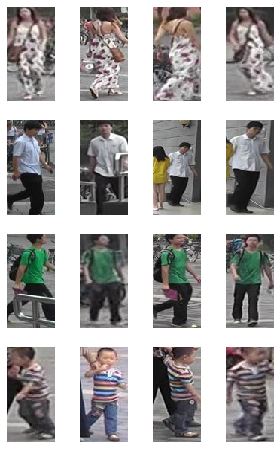

In [7]:
batch = train_generator.sample(4, 4, flatten=False, 
                             preprocess=False, 
                             img_dim=IMG_DIM)
plt.figure(figsize=(5, 8))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4*i+j+1)
        plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
        plt.axis('off')
plt.show()

In [8]:
batch.min(), batch.max()

(0, 255)

## Build Model

In [9]:
inputs, train_init_op, test_init_op = get_data_iterator_from_generator(train_generator, 
                                                                  (None,)+IMG_DIM, 
                                                                  n=NUM_BRANCHES)
print(inputs)

W0726 11:38:06.325123 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:182: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 11:38:06.346574 139657909835520 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the depre

[<tf.Tensor 'input_1:0' shape=(?, 128, 64, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 128, 64, 3) dtype=float32>]


In [10]:
lr = tf.placeholder('float32', name='lr')
# beta1 = tf.placeholder('float32', shape=[], name='beta1')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001)
# beta1_sched = beta1_scheduler(T_0)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, 
                               shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'resnet':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    elif ARCHITECTURE == 'densenet':
        model, assign_ops = DenseNet121(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
        
#     optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1)

#     # Compile model
#     model.compile(optimizer, triplet(P,K, margin='soft'), 
#                   train_init_op, test_init_op, 
#                   callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES, 
#                                               preprocess=ARCHITECTURE, 
#                                               buffer=1000, img_dim=IMG_DIM)},
#                   schedulers={'lr:0': lr_scheduler, 'beta1:0':beta1_sched},  
#                   assign_ops=assign_ops)

W0726 11:38:06.403652 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:169: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W0726 11:38:06.404183 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0726 11:38:06.404614 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:172: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0726 11:38:06.405107 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/slim.py:175: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 11:38:06.490554 139657909835520 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/pooling.py:56: The name tf.nn.max_pool

Loading weights for DenseNet121...


In [11]:
model.summary()

i    Layer name                      Output shape                      Num param  Inbound               
--------------------------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                                    
--------------------------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                                    
--------------------------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,134,70,3]                   0          input                 
                                     [None,134,70,3]                                                    
--------------------------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,64,32,16] [N

In [16]:
with TFSessionGrow() as sess:
    keras_model = KerasDenseNet121(weights='imagenet', input_shape=(128, 64, 3), include_top=False)
    n = 12
    ip = np.random.randn(1, 128, 64, 3)
    keras_layer = keras_model.layers[n+1]
    print(keras_layer.name)
    keras_output = sess.run(keras_layer.output, feed_dict={keras_model.input:ip, 
                                                           learning_phase():0})
    sess.run(tf.global_variables_initializer())
    sess.run(assign_ops)
    print(model.layers[n].name)
    sess.run(['test_init_op_{}'.format(i+1) for i in range(NUM_BRANCHES)], 
             feed_dict={'x:0':ip, 'batch_size:0':len(ip)})
    model_output = sess.run(list(model.layers[n].output))

conv2_block1_concat
conv2_block1_concat


In [17]:
print(keras_output[0].shape)
print(model_output[0][0].shape)

(32, 16, 96)
(1, 32, 16, 24)


In [18]:
keras_output[0][0,0,:32]

array([0.101248  , 0.04948986, 0.0658587 , 0.0840366 , 0.07129287,
       0.08046415, 0.        , 0.08676504, 0.        , 0.067945  ,
       0.0820358 , 0.20494595, 0.04907874, 0.1629493 , 0.1904838 ,
       0.        , 0.0488439 , 0.38178566, 0.18986687, 0.0901526 ,
       0.0707139 , 0.04263527, 0.0308603 , 0.5128565 , 0.04791244,
       0.36165574, 0.21353169, 0.04600805, 0.11153299, 0.13732855,
       0.        , 0.11537223], dtype=float32)

In [19]:
model_output[0][0][0, 0,0]

array([ 0.11110681,  0.04571715,  0.04935047,  0.08294396,  0.07085334,
        0.11110264,  0.        ,  0.0596308 ,  0.        ,  0.06768577,
        0.09888375,  0.53806394,  0.0462917 ,  0.20731577,  0.20126656,
        0.        ,  0.46895397, -0.21131788,  2.2539449 , -0.27394038,
       -0.19317077,  0.07830802,  0.2987646 ,  0.78922844], dtype=float32)

In [16]:
print(model.output)

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 128) dtype=float32>]


In [17]:
# model.layers[427].get_weights()

In [18]:
model.losses

{'loss_1': <tf.Tensor 'model/loss_1:0' shape=() dtype=float32>,
 'loss_2': <tf.Tensor 'model/loss_2:0' shape=() dtype=float32>}

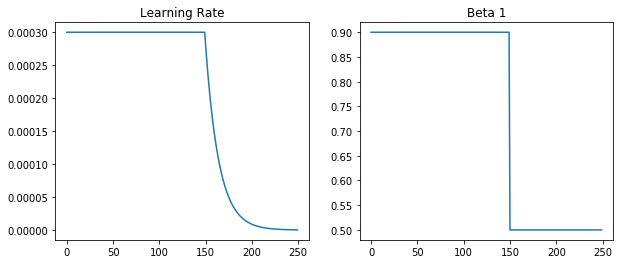

In [19]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
beta1_steps = [beta1_sched(e + 1) for e in range(EPOCHS)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lr_steps)
plt.title('Learning Rate')

plt.subplot(1,2,2)
plt.plot(beta1_steps)
plt.title('Beta 1')

plt.show()

In [20]:
# lr_steps[149]

In [21]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None, 
                    call_step=10, verbose=1)

Epoch 1/250
100/100 [==============================] - 652s 7s/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 1532.1360 - loss_2: 1177.2695
Epoch 2/250
100/100 [==============================] - 91s 906ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 289.1485 - loss_2: 209.1018
Epoch 3/250
100/100 [==============================] - 91s 905ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 143.0847 - loss_2: 138.8600
Epoch 4/250
100/100 [==============================] - 90s 902ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 113.8682 - loss_2: 134.5301
Epoch 5/250
100/100 [==============================] - 90s 904ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 102.0094 - loss_2: 122.7369
Epoch 6/250
100/100 [==============================] - 92s 919ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 103.1917 - loss_2: 111.9070
Epoch 7/250
100/100 [==============================] - 92s 916ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 99.5165 - los

KeyboardInterrupt: 

## Evaluation

In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=False)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 95s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 21s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 18.550950050354004
{'mAP': 0.6934945495051927, 'rank1': 0.8423397, 'rank5': 0.9403207}


In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=True)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 97s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 22s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 33.23809599876404
{'mAP': 0.6466024319270626, 'rank1': 0.8111639, 'rank5': 0.9275534}
